# Análise de variáveis do arquivo contendo os dados de diatomáceas
Este notebook segue a estrutura do script `analyse_co2_vars.py` para análise de variáveis biogeoquímicas do dataset DIATO.

In [2]:
# Importação de bibliotecas
import os
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4 as nc
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
os.getcwd()

'd:\\Users\\Mateus Francisco\\OneDrive\\Documentos\\UFPE\\Artigos\\artigo_sdena_co2\\Scripts'

In [ ]:
os.chdir(r'D:\Users\Mateus Francisco\OneDrive\Documentos\UFPE\Artigos\artigo_sdena_co2\Data')

SAVEPATH='D:\\Users\\Mateus Francisco\\OneDrive\\Documentos\\UFPE\\Artigos\\artigo_sdena_co2\\Results\\'

# Selecionar variável
VARIAVEL = 'SST'

FILE_NAME = 'DIATO_cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_1757962746741.nc'
ds = xr.open_dataset(FILE_NAME)

print(ds)

In [ ]:
DIATO = ds['DIATO']

time = ds['time']
lat = ds['latitude']
lon = ds['longitude']

print(DIATO)

In [5]:
# Initial setup
extent = [-70, -40, -60, -30]

var_config = {
    "DIATO": {
        "title": "Diatom Concentration",
        "units": "mg m$^{-3}$",
        "cmap": cmo.thermal,
        "limits": {
            "mean":       {"vmin": 0, "vmax": 5},
            "climatology":{"vmin": 0, "vmax": 3},
            "anomaly":    {"vmin": None, "vmax": None},
        }
    } 
}

month_names = {
    1:"Jan", 2:"Fev", 3:"Mar", 4:"Abr", 5:"Mai", 6:"Jun",
    7:"Jul", 8:"Ago", 9:"Set",10:"Out",11:"Nov",12:"Dez"
}

In [40]:
means = {}

for var in var_config.keys():
    means[var] = ds[var].mean(dim="time")

In [6]:
clim_monthly = {
    var: ds[var].groupby("time.month").mean("time")
    for var in var_config.keys()
}

In [51]:
anomalies = {
    var: ds[var].groupby("time.month") - clim_monthly[var]
    for var in var_config.keys()
}

In [52]:
def robust_sym_limits(arr, pct=98):
    # usa percentil robusto e impõe simetria ao redor de zero
    a = np.asarray(arr)
    vmax = np.nanpercentile(np.abs(a), pct)
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0
    return -vmax, vmax

In [ ]:
stats = {}

for var in var_config.keys():
    stats[var] = {
        "mean": {
            "min": float(means[var].min().values),
            "max": float(means[var].max().values),
        },
        "climatology": {
            "min": float(clim_monthly[var].min().values),
            "max": float(clim_monthly[var].max().values),
        },
        "anomaly": {
            "min": float(anomalies[var].min().values),
            "max": float(anomalies[var].max().values),
        },
    }

In [9]:
def plot_map(
    data, lat, lon, title, cmap, cbar_label,
    vmin=None, vmax=None, extent=None, savepath=None,
    add_contours=True,
    contour_levels=20,            # pode ser int (auto) ou lista/np.array de valores
    contour_color='k',
    contour_linewidth=0.5,
    contour_labels=False,
    contour_fmt="%.1f"
 ):
    
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111, projection=ccrs.PlateCarree())

    # Limites (lon_min, lon_max, lat_min, lat_max)
    if extent is not None:
        ax.set_extent(extent, crs=ccrs.PlateCarree())

    ax.set_aspect('equal')  # escala igual nos eixos

    # Base do mapa
    ax.coastlines(resolution="110m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightgrey")

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
    gl.xlocator = plt.MultipleLocator(10)   # longitude a cada 5°
    gl.ylocator = plt.MultipleLocator(5)   # latitude a cada 5°
    
    levels = np.arange(-2, 2.5, 0.5)
    
    # Campo preenchido
    im = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=30,
        vmin=vmin, vmax=vmax,
        cbar_kwargs={"label": cbar_label, "shrink": 1, "aspect": 20, "pad": 0.05}
    )

    # Isolinhas (opcional)
    if add_contours:
        contours = ax.contour(
            lon, lat, data,
            levels=contour_levels,
            colors=contour_color,
            linewidths=contour_linewidth,
            transform=ccrs.PlateCarree()
        )
        if contour_labels:
            ax.clabel(contours, inline=True, fontsize=8, fmt=contour_fmt)

    plt.title(title, fontsize=14)

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()

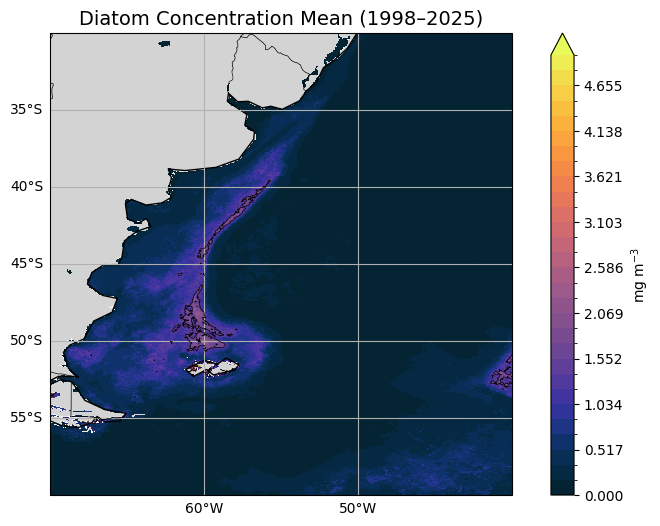

In [59]:
for var, cfg in var_config.items():
    plot_map(
        means[var],
        lat, lon,
        f"{cfg['title']} Mean (1998–2025)",
        cmap=cfg["cmap"],
        cbar_label=cfg["units"],
        extent=extent,
        add_contours=True,
        vmin=cfg["limits"]["mean"]["vmin"],
        vmax=cfg["limits"]["mean"]["vmax"],
        savepath=f"{SAVEPATH}_20levels-{var}_mean.png",
    )

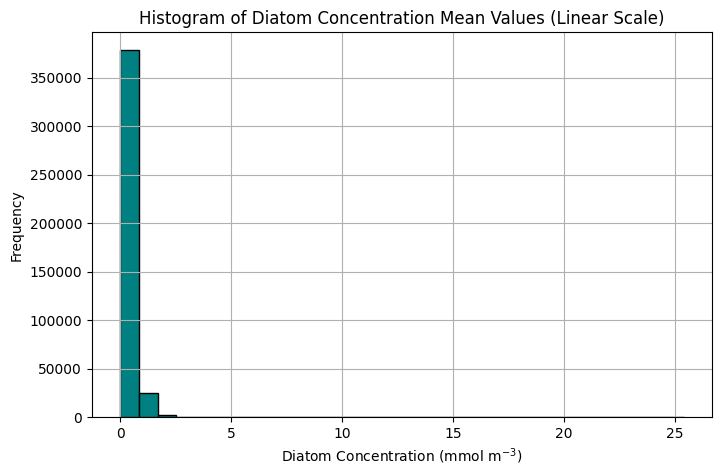

In [47]:
# Histogram of Diatom concentration mean values (linear scale on y-axis)
plt.figure(figsize=(8,5))
plt.hist(means['DIATO'].values.flatten(), bins=30, color='teal', edgecolor='black')
plt.xlabel('Diatom Concentration (mmol m$^{-3}$)')
plt.ylabel('Frequency')
plt.title('Histogram of Diatom Concentration Mean Values (Linear Scale)')
plt.grid(True)
plt.show()

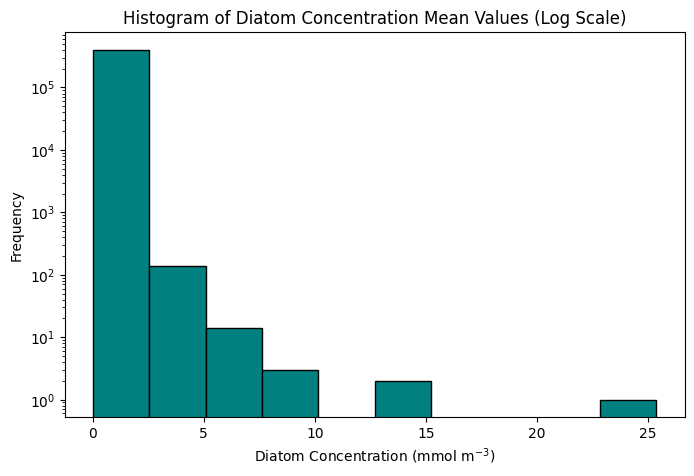

In [44]:
# Histogram of Diatom concentration mean values (log scale on y-axis)
plt.figure(figsize=(8,5))
plt.hist(means['DIATO'].values.flatten(), bins=10, color='teal', edgecolor='black')
plt.xlabel('Diatom Concentration (mmol m$^{-3}$)')
plt.ylabel('Frequency')
plt.title('Histogram of Diatom Concentration Mean Values (Log Scale)')
plt.yscale('log')
# plt.grid(True, which='both', axis='y')
plt.show()

In [34]:
# Show min and max values of Diatom concentration mean (ignoring NaNs)
import numpy as np
min_value = np.nanmin(means['DIATO'].values)
max_value = np.nanmax(means['DIATO'].values)
print(f"Min: {min_value}")
print(f"Max: {max_value}")

Min: 0.0009999993490055203
Max: 25.39178466796875


In [ ]:

for var, cfg in var_config.items():
    da_clim = clim_monthly[var]  # (month, lat, lon)
    for m in range(1, 13):
        field = da_clim.sel(month=m)

        plot_map(
            field,
            lat, lon,
            f"{cfg['title']} Climatology – {month_names[m]} (1998–2025)",
            cmap=cfg["cmap"],
            cbar_label=cfg["units"],
            extent=extent,
            vmin=cfg["limits"]["climatology"]["vmin"],
            vmax=cfg["limits"]["climatology"]["vmax"],
            savepath=f"{SAVEPATH}/Climatology/{var}_{m:02d}_climatology.png",
        )